# Intro

In this tutorial, we show how the simulation experiment for ARGEN was implemented and reproduce main results in the simulation section.

# Arguments and set up

To run the codes, **(i)** designate the directory, where ARGEN was cloned from the Github repository, **(ii)** number of CPU cores to be used for parallel jobs, **(iii)** the significance level $\alpha$ for descendant set search and the parent set search and **(iv)** the replication number of the simulation.

In [ ]:
DIR='/kmp0223/ARGEN/'
ncores=5
alpha_desc=alpha_IV = 0.05
repnum <- 100
options(future.globals.maxSize = 10 * 1024^3) # memory allowance for future function.

# Load functions

In [2]:
source(paste0(DIR,'/code/function/application/Proxy_IV_functions_parallel.R'))

# Generation of true underlying DAG and model parameters.

The codes below generates true underlying DAG **g_star**, by the function **make_block_dag_simple**.

In [3]:
dag_seed    <- 1 #Seed for DAGs
param_seed  <- 1 #Seed for parameters
assign_seed <- 1 #Seed for perturbation assignments.

p <- 8 # dimnesion of the DAG.

set.seed(dag_seed)
edges_vec <- make_block_dag_simple(prob_within = 0.9, prob_cross = 0.25, seed = 123)


g_star <- graph(edges = edges_vec, directed = TRUE)

set.seed(1)
layout_res <- layout_with_fr(g_star)# layout for DAG plotting.

#Parent node list for each gene.
parents_list <- lapply(1:p, function(j) {
  vj <- paste0("X", j)
  as_ids(neighbors(g_star, vj, mode = "in"))
})
names(parents_list) <- paste0("X", 1:p)

Warning message:
“`graph()` was deprecated in igraph 2.1.0.
ℹ Please use `make_graph()` instead.”


The codes below generates the edge coefficient values and the other paremters in the Structural Equation Model (SEM) of the true expression levels.

In [4]:
set.seed(param_seed)
a  <- rep(-5, p)       # tau_j (direct instrument effect for each j) on link scale
b0 <- -0.5             # intercept on link scale
bu <- -rep(0.5, p)     # confounder loading on link scale

B <- matrix(0, p, p, dimnames = list(paste0("X", 1:p), paste0("X", 1:p)))
for (j in 1:p) {
  if (length(parents_list[[j]]) > 0) {
    for (pa in parents_list[[j]]) {
      sign_j <- 2 * rbinom(1, 1, prob = 1/2) - 1
      B[paste0("X", j), pa] <- sign_j * 0.5
    }
  }
}

true_edges <- as.data.frame(as_edgelist(g_star), stringsAsFactors = FALSE)
colnames(true_edges) <- c("from","to")
true_edges$coef <- mapply(function(frm, to) B[to, frm], true_edges$from, true_edges$to)

# Preliminary steps for the simulation

The codes below make blank lists where the results of the simulation can be saved

In [5]:
nodes  <- paste0("X", 1:p)
results_list <- list()
ii <- 0
control_ratio=50
DAG_results_nested <- list()


# Collect per-rep coefficients across analyses/methods
coef_long <- data.frame(
  method   = character(),
  analysis = character(),   # "Full" or "Omitted"
  from     = character(),
  to       = character(),
  coef     = numeric(),
  rep      = integer(),
  stringsAsFactors = FALSE
)


Define which genes (nodes) to drop from the simulation and define the edges that involve the dropped nodes.

In [6]:

# The drop set
DROP_NODES <- c("X7","X8")

# Edges to evaluate: only those NOT erased by dropping X7/X8
keep_nodes <- setdiff(nodes, DROP_NODES)
eval_edges <- true_edges %>%
  dplyr::filter(!(from %in% DROP_NODES | to %in% DROP_NODES)) %>%
  dplyr::mutate(edge = paste(from, "->", to))




# Generation of perturbation indicator matrix **D**.

In [7]:

n=8000  
set.seed(1)
  # continuous latent variable
  L <- rnorm(n,sd=1)
  
  # target control proportion
  c_target <- control_ratio / (p + control_ratio)
  
  # logistic parameters
  
  a_vec <- rep(0, p)
  b_vec <- rep(1, p)
  
  # choose a0 to hit desired control fraction (closed form)
  a0 <- 0 + log(p) - log(1 / c_target - 1)
  aL <- 5
  
  # compute softmax probabilities
  eta_guides  <- outer(L, b_vec) + matrix(rep(a_vec, each = n), n, p)
  eta_control <- a0 + aL * L
  eta_all <- cbind(eta_control, eta_guides)
  eta_all <- sweep(eta_all, 1, apply(eta_all, 1, max), "-")
  prob <- exp(eta_all); prob <- prob / rowSums(prob)
  
  # sample one label per cell
  Z <- apply(prob, 1, function(pr) sample.int(p + 1, 1, prob = pr) - 1L)
  
  # build D matrix and control indicator
  D <- matrix(0L, n, p, dimnames = list(NULL, nodes))
  nz <- which(Z > 0L)
  D[cbind(nz, Z[nz])] <- 1L
  control_ind <- (Z == 0L)

# Implementation of simulation experiments

The for loop below runs the following across **repnum** times of replication.

1. Generate count matrix X_raw based on SEM and D and L.
2. Run ARGEN on full nodes (descendant search -> parent and DAG estimation).
3. Run ARGEN on partial nodes dropping $X_7$ and $X_8$ (descendant search -> parent and DAG estimation).


In [8]:
for(data_seed in 1:repnum){
message("  data_seed = ", data_seed)
    
# Generation of the count matrix X_raw based on the SEM and other variables L and D.
sim <- simulate_X_capped(
      data_seed, D, L, parents_list, a, B,
      b0 = b0, bu = bu, cap = 1e5, max_tries = 200,
      seed_jump = 10000, verbose = FALSE, family = "poisson"
    )
    
    cc_df  <- data.frame(L = L)
    X_raw  <- sim$X
    C      <- sim$C
    X_norm <- sweep(X_raw, 1, C, FUN = "/")
        
    
ds_out_adj <- build_descendants_cov_adjust(
      X_raw = X_raw, D = D, control_ind = control_ind,
      alpha_desc = alpha_desc, nodes = nodes, padj_method = "BH",
      cc_cols = c("L"), cc_df = cc_df,engine ="multisession",depth=C,blas_threads=1,ncores=ncores
    )
        

result_IV <- dag_search_perturbseq(
      desc_sets = ds_out_adj$descendant_set_score_closure, data_raw = X_raw,
      D = D, depth = C, family = "poisson",
      cc_df = cc_df, cc_cols = c("L"),
      alpha_parent = alpha_IV, padj_method_parent = 'onlineBH',cores=ncores
    )
    g_IV_full  <- graph_from_result(result_IV, nodes)
    DAG_results_nested$IV[[as.character(n)]][[as.character(data_seed)]] <- result_IV
    coef_IV_full    <- df_from_result(result_IV)
    
    
    keep_nodes <- setdiff(nodes, DROP_NODES)
    if (length(DROP_NODES)) {
      drop_row <- rowSums(D[, DROP_NODES, drop = FALSE] == 1) > 0
      keep_rows <- !drop_row
    } else {
      keep_rows <- rep(TRUE, nrow(D))
    }
    
    D_sub      <- D[keep_rows, keep_nodes, drop = FALSE]
    X_raw_sub  <- X_raw[keep_rows, keep_nodes, drop = FALSE]
    C_sub      <- C[keep_rows]
    X_norm_sub <- sweep(X_raw_sub, 1, C_sub, "/")
    control_ind_sub <- rowSums(D_sub) == 0
    cc_df_sub=cc_df[keep_rows,,drop=FALSE]
    
    ds_out_adj_sub <- build_descendants_cov_adjust(
      X_raw = X_raw_sub, D = D_sub, control_ind = control_ind_sub,
      alpha_desc = alpha_desc, nodes = keep_nodes, padj_method = "BH",
      cc_cols = c("L"), cc_df = cc_df_sub,engine ="multisession",depth=C_sub,blas_threads=1,ncores=ncores
    )
    
    result_IV_sub <- dag_search_perturbseq(
      desc_sets = ds_out_adj_sub$descendant_set_score_closure, data_raw = X_raw_sub,
      D = D_sub, depth = C_sub, family = "poisson",
      cc_df = cc_df_sub, cc_cols = c("L"),
      alpha_parent = alpha_IV, padj_method_parent = 'onlineBH',cores=ncores
    )
    DAG_results_nested$IV_sub[[as.character(n)]][[as.character(data_seed)]] <- result_IV_sub
    g_IV_drop_embed    <- embed_graph(result_IV_sub,    nodes)
    coef_IV_sub    <- df_from_result(result_IV_sub)
   
        # ===========================
    coef_long <- dplyr::bind_rows(
      coef_long,
      add_rows(coef_IV_full,     "IV",    "Full",    data_seed),
      add_rows(coef_IV_sub,      "IV",    "Omitted", data_seed)
    )
    
}

  data_seed = 1



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 2



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 3



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 4



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 5



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 6



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 7



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 8



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 9



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 10



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 11



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 12



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 13



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 14



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 15



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 16



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 17



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 18



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 19



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 20



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 21



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 22



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 23



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 24



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 25



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 26



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 27



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 28



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 29



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 30



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 31



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 32



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 33



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 34



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 35



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 36



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 37



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 38



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 39



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 40



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 41



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 42



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 43



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 44



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 45



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 46



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 47



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 48



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 49



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 50



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 51



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 52



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 53



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 54



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 55



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 56



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 57



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 58



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 59



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 60



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 61



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 62



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 63



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 64



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 65



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 66



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 67



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 68



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 69



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 70



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 71



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 72



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 73



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 74



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 75



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 76



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 77



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 78



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 79



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 80



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 81



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 82



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 83



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 84



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 85



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 86



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 87



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 88



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 89



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 90



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 91



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 92



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 93



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 94



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 95



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 96



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 97



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 98



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 99



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


  data_seed = 100



Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done


# Visualizations

## DAG visualization

The lines of codes below generates graph features of the true DAG and the estimated DAGs.

In [9]:
set.seed(dag_seed)
layout_ref <- layout_with_fr(g_star); rownames(layout_ref) <- V(g_star)$name

global_max <- max(
  abs(true_edges$coef),
  if (nrow(coef_IV_full))        max(abs(coef_IV_full$coef),        na.rm = TRUE) else 0,
  if (nrow(coef_IV_sub))         max(abs(coef_IV_sub$coef),         na.rm = TRUE) else 0,
  na.rm = TRUE
)
if (!is.finite(global_max) || global_max <= 0) global_max <- 1

g_star_plot   <- apply_edge_aesthetics(g_star,       true_edges)
g_IV_plot     <- apply_edge_aesthetics(g_IV_full,    coef_IV_full)
g_IV_drop_plot     <- apply_edge_aesthetics(g_IV_drop_embed,    coef_IV_sub)


# Grey-out dropped nodes in estimated graphs
vcol_full <- setNames(rep("gray90", length(nodes)), nodes)
vcol_est  <- setNames(ifelse(nodes %in% DROP_NODES, "yellow", "gray95"), nodes)
vlab_col  <- setNames(ifelse(nodes %in% DROP_NODES, "gray40", "black"), nodes)



The codes below visualizes the true DAG and the estimated DAG, learned from an analysis that uses data without the dropped nodes $X_7$ and $X_8$. The resulting figure corresponds to the panels for the true DAG and the estimated DAG of ARGEN in Figure 2a.

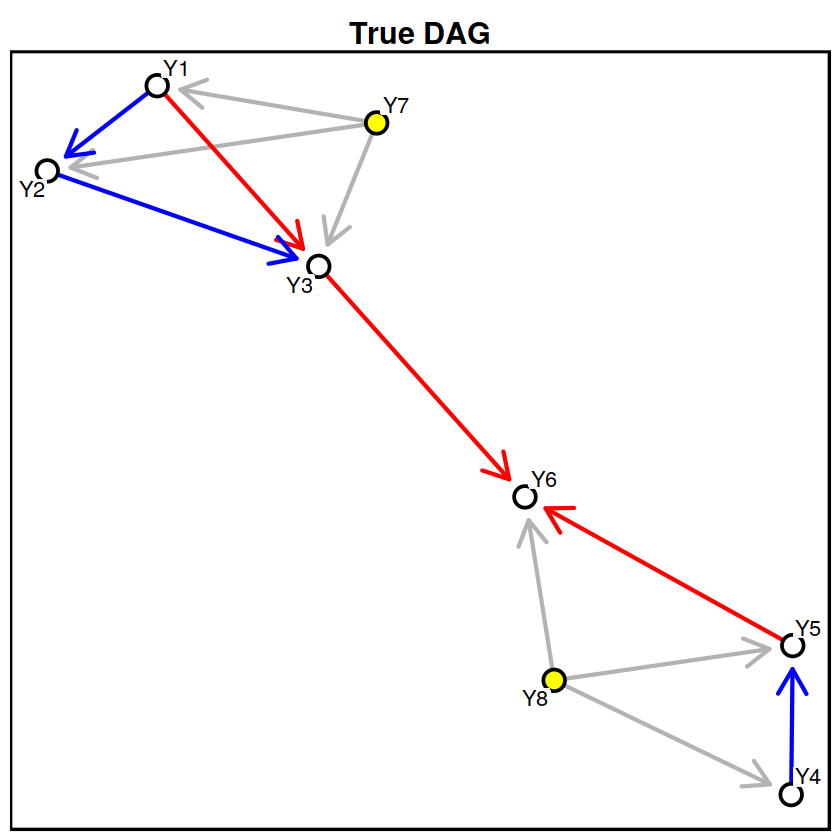

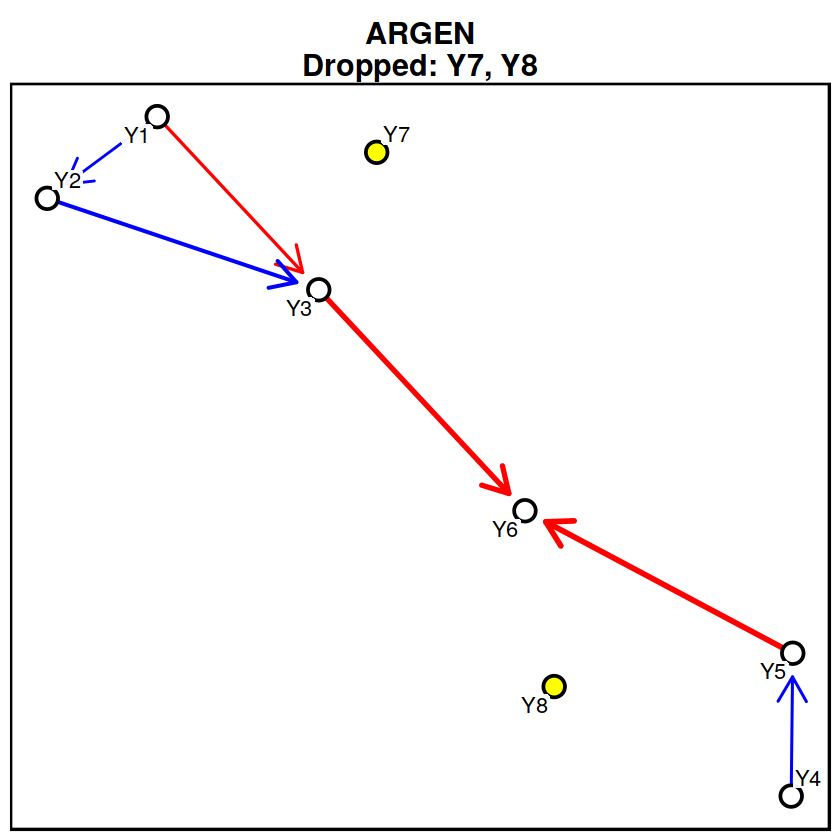

In [10]:
suppressPackageStartupMessages({
  library(dplyr); library(tidyr); library(tibble)
  library(igraph); library(ggraph); library(scales)
  library(patchwork); library(grid); library(ggplot2)
})

# ------- Shared layout-------
set.seed(dag_seed)
layout_ref <- layout_with_fr(g_star); rownames(layout_ref) <- V(g_star)$name
posdf <- tibble(name = rownames(layout_ref), x = layout_ref[,1], y = layout_ref[,2])

# ------- Global edge width scaling anchor -------
global_max <- max(
  abs(true_edges$coef),
  if (exists("coef_IV_sub") && nrow(coef_IV_sub))         max(abs(coef_IV_sub$coef),         na.rm = TRUE) else 0,
  na.rm = TRUE
)
if (!is.finite(global_max) || global_max <= 0) global_max <- 1

# ------- Helper: make a ggraph panel from an edge df -------
# df_edges must have columns: from, to, coef
plot_one <- function(df_edges, all_nodes, posdf, title = "", dropped = character(0),
                     edge_label_size = 3.3, node_label_size = 4.5) {
  # graph & node frame
  g <- graph_from_data_frame(df_edges, directed = TRUE,
                             vertices = tibble(name = all_nodes))
  
  
  V(g)$name <- sub("^X", "Y", V(g)$name)
  # make dropped labels consistent
  dropped <- sub("^X", "Y", dropped)
  # make posdf$name consistent
  posdf$name <- sub("^X", "Y", posdf$name)
  
  
  V(g)$dropped <- V(g)$name %in% dropped
  E(g)$coef <- as.numeric(df_edges$coef)
  E(g)$absw <- pmin(abs(E(g)$coef) / global_max, 1)  # normalize by global max
  E(g)$w_plot <- scales::rescale(sqrt(E(g)$absw), to = c(0.6, 1.2))
  
  # edge colors by sign
  # E(g)$col <- ifelse(E(g)$coef < 0, "red", "blue")
  
  edge_from <- igraph::ends(g, igraph::E(g), names = TRUE)[,1]
  edge_to   <- igraph::ends(g, igraph::E(g), names = TRUE)[,2]
  E(g)$col <- ifelse(edge_from %in% dropped | edge_to %in% dropped,
                     "gray70",
                     ifelse(E(g)$coef < 0, "red", "blue"))
  
  
  # manual coordinates
  xy <- posdf[match(V(g)$name, posdf$name), c("x","y")]
  
  # midpoints for labels
  edges_df <- igraph::as_data_frame(g, what = "edges") %>%
    mutate(
      x = (xy$x[match(from, posdf$name)] + xy$x[match(to, posdf$name)]) / 2,
      y = (xy$y[match(from, posdf$name)] + xy$y[match(to, posdf$name)]) / 2,
      coef_lab = sprintf("%.2f", coef),
      lab_col  = ifelse(coef < 0, "red", "blue")
    )
  
  ggraph(g, layout = "manual", x = xy$x, y = xy$y) +
    geom_edge_link(
      aes(edge_width = w_plot, edge_colour = col),
      arrow     = arrow(length = unit(6, "mm")),
      start_cap = circle(2, "mm"),
      end_cap   = circle(5, "mm"),
      lineend   = "round",
      alpha = 1, show.legend = FALSE
    ) +  geom_node_point(
      aes(fill = ifelse(dropped, "yes", "no")),
      size = 5, stroke = 1.2, shape = 21, color = "black"
    ) +
    geom_node_label(
      aes(label = name),
      repel = TRUE,
      label.size = 0,
      label.padding = unit(0.1, "lines"),
      label.r = unit(0.12, "lines"),
      fill = scales::alpha("white", 0.95),
      size = node_label_size
    ) +
    scale_edge_colour_identity() +
    scale_edge_width(range = c(0.6, 1.2)) +
    scale_color_identity(na.translate = FALSE) +
    scale_fill_manual(values = c(no = "white", yes = "yellow")) +
    ggtitle(title) +
    theme_void(base_size = 14) +
    theme(legend.position = 'none',
      plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
      panel.border = element_rect(colour = "black", fill = NA, linewidth = 1.2),
      plot.margin = margin(6, 6, 6, 6)
    )
}



all_nodes <- V(g_star)$name
dropped   <- c("Y7","Y8")#DROP_NODES


p_true   <- plot_one(true_edges, all_nodes, posdf, title = "True DAG", dropped = DROP_NODES)
p_iv     <- plot_one(coef_IV_sub,      all_nodes, posdf,
                     title = sprintf("ARGEN\nDropped: %s", paste(dropped, collapse = ", ")),
                     dropped = dropped)


p_true ;p_iv

## Coefficient estimates

The codes below visualizes the coefficient values of the edges in the estimated DAGs across **repnum** number of replicates. The resulting figure corresponds to the panel for ARGEN in Figure 2b of the manuscript.

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_text()`).”


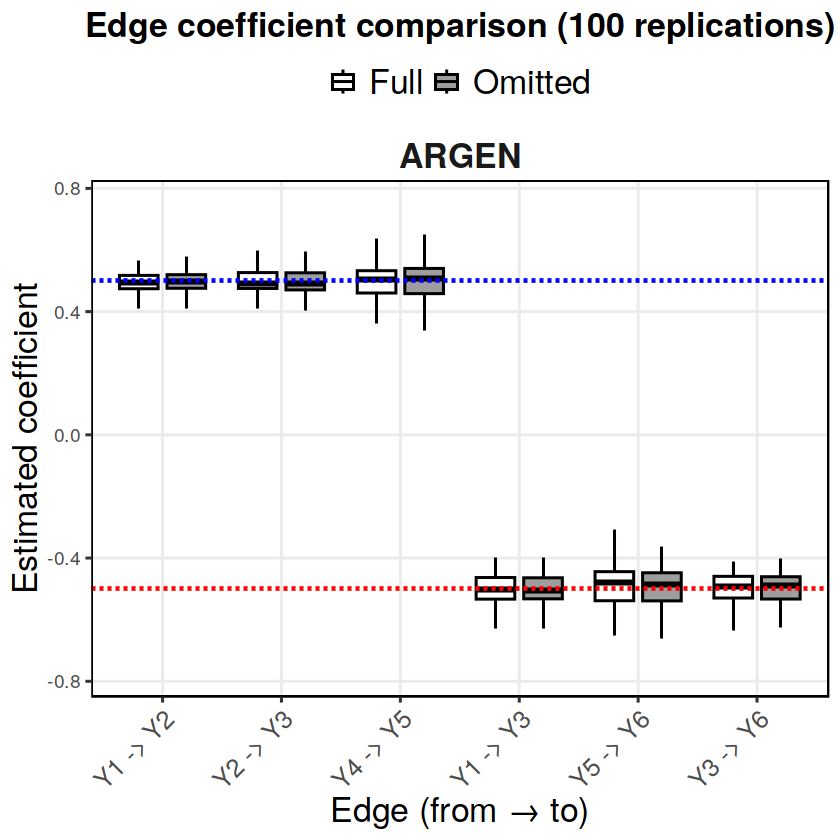

In [11]:
# Ensure we have a key for each evaluated edge and replicate, so missing fits are NA
edge_keys <- eval_edges %>% dplyr::select(from, to, edge)
key_grid <- expand.grid(
  method   = c("IV"),
  analysis = c("Full","Omitted"),
  rep      = seq_len(repnum),
  edge     = edge_keys$edge,
  stringsAsFactors = FALSE
) %>%
  dplyr::left_join(edge_keys, by = "edge")



# Attach edge key to collected coefficients
coef_long$edge <- paste(coef_long$from, "->", coef_long$to)

# Left join to include missing combos (will be NA and ignored by boxplot stats)
comp_df <- key_grid %>%
  dplyr::left_join(
    coef_long %>% dplyr::select(method, analysis, rep, edge, coef),
    by = c("method","analysis","rep","edge")
  )

# Order edges by true absolute magnitude (optional but nice)
# edge_order <- eval_edges %>%
#   dplyr::arrange(dplyr::desc(abs(coef))) %>%
#   dplyr::pull(edge)
# comp_df$edge <- factor(comp_df$edge, levels = edge_order)

edge_order <- eval_edges %>%
  mutate(
    from_Y = sub("^X", "Y", from),
    to_Y   = sub("^X", "Y", to),
    edge   = paste(from_Y, "->", to_Y)
  ) %>%
  arrange(desc(coef > 0), desc(abs(coef))) %>%
  pull(edge)

## 2) Build comp_df$edge from from/to (X→Y) and apply ordering
comp_df <- comp_df %>%
  mutate(
    from_Y = sub("^X", "Y", from),
    to_Y   = sub("^X", "Y", to),
    edge   = paste(from_Y, "->", to_Y),
    edge   = factor(edge, levels = edge_order)
  )

# Draw
# ===========================
# BOX PLOTS: Full vs Omitted per edge (vertical)
# ===========================
library(dplyr)
library(ggplot2)
comp_df$method[comp_df$method=="IV"]="ARGEN"
comp_df$method <- factor(comp_df$method, levels = c("ARGEN"))
## 1) Wilcoxon test per facet (method) and x-axis (edge)
stat_df <- comp_df %>%
  filter(analysis %in% c("Full", "Omitted")) %>%         # just in case
  group_by(method, edge) %>%
  filter(dplyr::n_distinct(analysis) == 2) %>%           # need both groups
  summarise(
    p = wilcox.test(coef ~ analysis, exact = FALSE)$p.value,
    y = max(coef) + 0.12 * diff(range(coef)),            # position for star
    .groups = "drop"
  ) %>%
  mutate(
    label = case_when(
      p < 0.001 ~ "***",
      p < 0.01  ~ "**",
      p < 0.05  ~ "*"
    )
  )


p_box <- ggplot(comp_df, aes(x = edge, y = coef, fill = analysis)) +
  geom_boxplot(
    outlier.shape = NA, width = 0.65,
    position = position_dodge(width = 0.8),
    color = "black", alpha = 0.95
  ) +
  geom_hline(yintercept = 0.5, linewidth = 1,
             linetype = "dashed", color = "blue") +
  geom_hline(yintercept = -0.5, linewidth = 1,
             linetype = "dashed", color = "red") +
  facet_wrap(~ method, nrow = 1, scales = "fixed") +
  scale_fill_manual(values = c("Full" = "white", "Omitted" = "gray60")) +
  labs(
    x = "Edge (from \u2192 to)",
    y = "Estimated coefficient",
    fill = "",
    title = paste0("Edge coefficient comparison (", repnum, " replications)")
  ) +
  theme_bw(base_size = 14) +
  theme(
    legend.position = "top",
    legend.text = element_text(size = 20),
    legend.title = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
    axis.title = element_text(size = 20),
    plot.title = element_text(face = "bold", size = 20, hjust = 0.5),
    plot.subtitle = element_text(size = 20, hjust = 0.5),
    strip.background = element_blank(),
    strip.text = element_text(size = 20, face = "bold"),
    panel.border = element_rect(colour = "black", fill = NA)
  ) +
  ## add stars; inherit.aes = FALSE so we use only stat_df aesthetics
  geom_text(
    data = stat_df,
    aes(x = edge, y = y, label = label),col="red",
    inherit.aes = FALSE,
    size = 6
  )

print(p_box)
